## Workflow for 'Graylevel Radial Analysis of Particles in ElectrodeS (GRAPES)'

#### In this notebook we look at how the internal grelevel of particles changes during cycling.

#### NMC electrode is cycled by charging from 4.0V to 4.4V and then discharging from 4.4V - 4.0V, 3.8V, 2.5V

#### The following image processing steps are used:

##### - Image Registration using SimpleITK

##### - Filtering and Segmentation of active material phase using NLM and thresholding (+ some other morhological operations)

##### - Instance segmentation (labelling) of particles consistently between scans using a marker based watershed threshold 

##### - Analysis of particles using the new GRAPES algorothm

In [1]:
# imports

import numpy as np
import numpy.ma as ma
import imageio as io
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

import GRAPES as gps
from para_nlm import paranlm

from skimage.filters import gaussian
from skimage.morphology import cube, erosion, dilation, remove_small_holes
from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops_table

import scipy.ndimage as nd
from scipy.ndimage import distance_transform_edt as dist_trans


## Image Registration is SimpleITK

In [ ]:
# initialise the registration
def my_initialisation(fixed_image, moving_image):
    initial_transform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    reg = sitk.ImageRegistrationMethod()    
    reg.SetMetricAsMattesMutualInformation()
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.001)
    reg.SetInterpolator(sitk.sitkNearestNeighbor)  # This is the least computationally demanding interpolator 
    reg.SetOptimizerAsExhaustive(numberOfSteps=[0,0,0,8,8,8], stepLength = 1) 
    reg.SetOptimizerScales([1,1,1,1,1,1])
    reg.SetInitialTransform(initial_transform, inPlace=False)
    return reg.Execute(fixed_image, moving_image)

# defines function that registers 'moving images' to 'fixed_images' with step length = 5
def my_registration(fixed_image, moving_image):
    reg = sitk.ImageRegistrationMethod()    
    reg.SetMetricAsMeanSquares()
    reg.SetMetricSamplingStrategy(reg.RANDOM)
    reg.SetMetricSamplingPercentage(0.008)
    reg.SetInterpolator(sitk.sitkNearestNeighbor)  # This is the least computationally demanding interpolator 
    reg.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=1000, convergenceMinimumValue=1e-8, convergenceWindowSize=50)
    reg.SetOptimizerScalesFromPhysicalShift()
    reg.SetInitialTransform(initial_transform, inPlace=False)
    return reg.Execute(fixed_image, moving_image), reg.GetMetricValue()
    
# this function executes a transformation
def resample(image, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    reference_image = image
    interpolator = sitk.sitkNearestNeighbor
    default_value = 105
    return sitk.Resample(image, reference_image, transform, interpolator, default_value)

In [ ]:
scans = []
transform_vals = []
metric_vals = []

fixed_image = sitk.ReadImage(f'H:/data_files_for_grapes/132037/GREY_132037.tif', sitk.sitkFloat32)
print(f'\nFixed Volume is Scan 132037')
for scan_num in range(132038,132048,1):
    moving_image = sitk.ReadImage(f'H:/data_files_for_grapes/{scan_num}/GREY_{scan_num}.tif', sitk.sitkFloat32)
    print(f'\nMoving Volume is Scan {scan_num}\n')
    initial_transform = my_initialisation(fixed_image, moving_image)
    print(f'Initialisation: \n{initial_transform.GetParameters()}\n')
    initial_transform, test = my_registration(fixed_image, moving_image)
    print(f'Registration : \n{initial_transform.GetParameters()}\nWith MSE of {test}\n')
    counter = 0
    while counter <= 9:
        counter += 1
        print(f'Iteration {counter}:')
        transform_x, test_x = my_registration(fixed_image, moving_image)
        if test > test_x:
            print(f'Transform Improves Metric:\n {transform_x.GetParameters()}')
            test = test_x
            initial_transform = transform_x
        else:
            print('Transform Worsens Metric')
            break
    print(f'\nResampling with \n {initial_transform.GetParameters()} \n With MSE of {test}')
    moving_image = resample(moving_image, initial_transform)
    scans.append(scan_num)
    transform_vals.append(initial_transform.GetParameters())
    metric_vals.append(test)
    io.volwrite(f'H:/data_files_for_grapes/{scan_num}/GREYREG_{scan_num}.tiff', sitk.GetArrayFromImage(moving_image).astype(np.uint8), format = 'tiff')
    fixed_image = moving_image
    print(f'\nFixed Volume is Scan {scan_num}')

data = {'Scan':scans, 'Tranforms':transform_vals, 'Metric_Value':metric_vals}
df = pd.DataFrame(data, columns = ['Scan', 'Transforms', 'Metric_Value'])
df.to_csv('registration_transforms.csv')

## Filtering (NLM) 

In [ ]:
def apply_nlm(image):
    img = img_as_float(image) ###load image to be smoothed by NLM.
    img = denoise_nl_means(img, h=0.00472*smoothing, fast_mode=True, patch_size=10, patch_distance=15)  
    return (img*255).astype(np.uint8)

im = io.volread(f'H:/data_files_for_grapes/132037/GREY_132037.tif')[250]

filter_bank = []
for smoothing in tqdm(range(12)):
    smoothed = apply_nlm(im)
    filter_bank.append(smoothed)

io.volwrite('filter_bank.tiff', np.array(filter_bank), format = 'tiff')

In [ ]:
# Best smoothing factor is 1, this is used in para_nlm.py
# run the paralelised nlm in main (para_nlm.py)

paranlm()

# writes filtered volumes to working directory

## Segmentation of Active Material

In [ ]:
# create segmentation of active material from the smoothed dataset 
for scan_num in tqdm(range(132037,132048,1)):
    vol1 = io.volread(f'H:/data_files_for_grapes/{scan_num}/NLM_{scan_num}.tiff')
    vol2 = np.where(vol1 >= 106, 1, 0)
    vol2 = erosion(dilation(vol2, cube(3)), cube(3))
    vol2 = dilation(erosion(vol2, cube(3)), cube(3))
    vol2 = np.where(vol1*vol2 >= 104, 1, 0)
    for i in range(vol2.shape[0]):
        vol2[i] = remove_small_holes(vol2[i], 2000).astype(np.uint8)
    io.volwrite(f'H:/data_files_for_grapes/{scan_num}/SEG_{scan_num}.tiff', vol2.astype(np.uint8), format = 'tiff')

In [ ]:
# cropping everything so same shape and to remove pads from registration step
for vol_type in ['GREYREG','NLM','SEG']:
    for scan_num in tqdm(range(132037,132048,1)):
        volume = io.volread(f'H:/data_files_for_grapes/{scan_num}/{vol_type}_{scan_num}.tiff')
        if volume.shape == (456, 1339, 498):
            volume = volume[10:-10,:-1,:-1]
            io.volwrite(f'H:/data_files_for_grapes/{scan_num}/{vol_type}_{scan_num}.tiff', volume, format = 'tiff')
        else:
            volume = volume[10:-9,:,:]
            io.volwrite(f'H:/data_files_for_grapes/{scan_num}/{vol_type}_{scan_num}.tiff', volume, format = 'tiff')

## Instance Segmentation (labeling) of Particles using a marker based watershed

In [ ]:
volume = io.volread(f'H:/data_files_for_grapes/132037/SEG_132037.tiff')
dist = dist_trans(volume)
dist_blur = gaussian(dist, sigma=1.3, preserve_range = True)
dist_blur = np.where(volume == 0, 0, dist_blur)
io.volwrite(f'H:/data_files_for_grapes/132037/DIST_132037.tiff', dist_blur.astype(np.uint8), format = 'tiff')
coords = peak_local_max(dist_blur, footprint=np.ones((9, 9, 9)), labels=volume)
mask = np.zeros(volume.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = nd.label(mask)
labels = watershed(-dist_blur, markers, mask=volume)
io.volwrite(f'H:/data_files_for_grapes/132037/LABEL_132037.tiff', labels.astype(np.uint16), format = 'tiff')

In [ ]:
for scan_num in tqdm(range(132038,132048,1)):
    volume = io.volread(f'H:/data_files_for_grapes/{scan_num}/SEG_{scan_num}.tiff')
    dist = dist_trans(volume)
    dist_blur = gaussian(dist, sigma=1.3, preserve_range = True)
    dist_blur = np.where(volume == 0, 0, dist_blur)
    labels = watershed(-dist_blur, markers, mask=volume)
    io.volwrite(f'H:/data_files_for_grapes/{scan_num}/LABEL_{scan_num}.tiff', labels.astype(np.uint16), format = 'tiff')

## GRAPES analysis

In [2]:
#data for GRAPES
labels_array = io.volread('H:/data_files_for_grapes/132037/LABEL_132037.tiff')
grey_array = io.volread('H:/data_files_for_grapes/132037/GREYREG_132037.tiff')

In [3]:
# GRAPES Analysis example normalising to the radial maximum and calculating the distance transform from the edge
grapes_analysis_1 = gps.GRAPES(labels_array, grey_array, normalised_by = 'radial_max', start_at = 'edge')
grapes_analysis_1.head()

,label,volume,centroid-0,centroid-1,centroid-2,centroid_local-0,centroid_local-1,centroid_local-2,axis_major_length,equivalent_diameter_volume,intensity_max,intensity_mean,intensity_min,image,image_intensity,GRAPES_RP,GRAPES_GL,GRAPES_GL_NORMED,GRAPES_distance_transform
0,1,34.0,0.500000,0.941176,307.647059,0.500000,0.941176,2.647059,7.363004,4.019390,116.0,111.500000,107.0,"[[[True, True, True, True, True, True], [True,...","[[[109, 112, 113, 115, 114, 112], [110, 112, 1...",[],[],[],"[[[[0. 0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. ..."
1,2,15534.0,8.229110,13.141882,151.679349,8.229110,13.141882,19.679349,39.462774,30.957192,122.0,111.721450,102.0,"[[[False, False, False, False, True, True, Tru...","[[[0, 0, 0, 0, 110, 113, 116, 113, 114, 113, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[110.26593521421108, 112.74286759326993, 112.7...","[0.97743505, 0.99939144, 0.99928087, 1.0, 0.99...",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2,3,2362.0,3.404318,14.279424,110.723116,3.404318,10.279424,9.723116,23.892317,16.523185,121.0,112.374682,104.0,"[[[False, False, False, False, False, False, F...","[[[0, 0, 0, 0, 0, 0, 0, 0, 107, 108, 110, 113,...","[1, 2, 3, 4]","[110.35911602209944, 113.68506493506493, 114.2...","[0.961352, 0.99032474, 0.99555063, 1.0]",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,4,948.0,1.667722,40.470464,329.252110,1.667722,8.470464,9.252110,18.686694,12.188116,120.0,112.637131,106.0,"[[[False, False, False, False, False, False, F...","[[[0, 0, 0, 0, 0, 0, 0, 111, 113, 112, 112, 0,...","[1, 2]","[111.54416403785488, 114.68951612903226]","[0.97257507, 1.0]",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,5,345.0,1.321739,42.768116,109.194203,1.321739,4.768116,7.194203,15.640304,8.701754,120.0,111.834783,104.0,"[[[False, False, False, False, False, False, T...","[[[0, 0, 0, 0, 0, 0, 111, 111, 113, 113, 0, 0,...",[1],[111.1985559566787],[1.0],[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


In [4]:
#find the largest particle, a.k.a. the chonker
chonk = grapes_analysis_1[grapes_analysis_1['volume'] == grapes_analysis_1['volume'].max()]
print(chonk['label'])

9754    9755
Name: label, dtype: int32


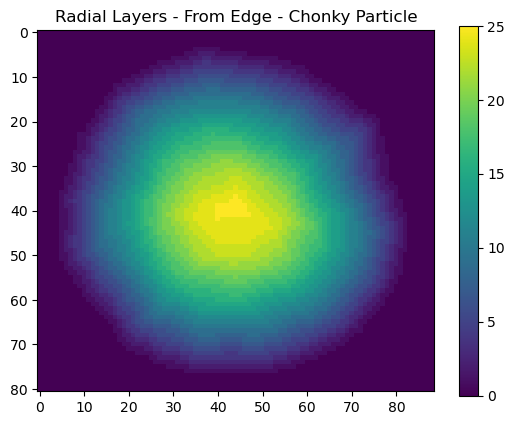

In [5]:
plt.imshow(np.array(grapes_analysis_1['GRAPES_distance_transform'][9754])[0][27], cmap = 'viridis')
plt.title('Radial Layers - From Edge - Chonky Particle')
color_bar = plt.colorbar()
plt.show()

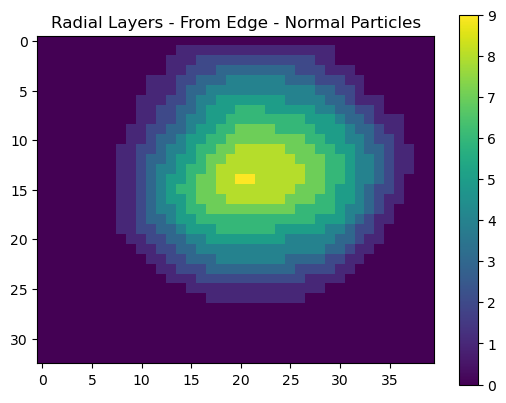

In [6]:
plt.imshow(np.array(grapes_analysis_1['GRAPES_distance_transform'][1])[0][15], cmap = 'viridis')
plt.title('Radial Layers - From Edge - Normal Particles')
color_bar = plt.colorbar()
plt.show()

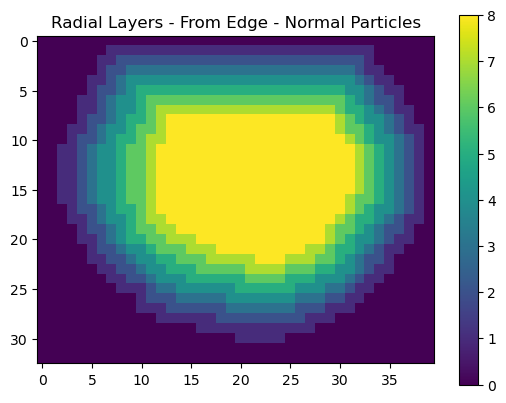

In [7]:
plt.imshow(np.array(grapes_analysis_1['GRAPES_distance_transform'][1])[0][8], cmap = 'viridis')
plt.title('Radial Layers - From Edge - Normal Particles')
color_bar = plt.colorbar()
plt.show()

In [8]:
# GRAPES Analysis example normalising to the surface graylevel and calculating distance tranform from the centroid
grapes_analysis_2 = gps.GRAPES(labels_array, grey_array, normalised_by = 'surface', start_at = 'center')
grapes_analysis_2.head()

h:\data_files_for_grapes\GRAPES.py:124: UserWarning: Warning: converting a masked element to nan.
  gl = np.array(gl)
h:\data_files_for_grapes\GRAPES.py:125: UserWarning: Warning: converting a masked element to nan.
  norm_gl = np.array(norm_gl)


,label,volume,centroid-0,centroid-1,centroid-2,centroid_local-0,centroid_local-1,centroid_local-2,axis_major_length,equivalent_diameter_volume,intensity_max,intensity_mean,intensity_min,image,image_intensity,GRAPES_RP,GRAPES_GL,GRAPES_GL_NORMED,GRAPES_distance_transform
0,1,34.0,0.500000,0.941176,307.647059,0.500000,0.941176,2.647059,7.363004,4.019390,116.0,111.500000,107.0,"[[[True, True, True, True, True, True], [True,...","[[[109, 112, 113, 115, 114, 112], [110, 112, 1...","[1, 2, 3, 4]","[1.0, 0.99404764, 0.9980159, 0.99900794]","[112.0, 111.33333333333333, 111.77777777777777...","[[[[0. 0. 0. 0. 0. 0. 0. 0.], [0. 0. 0. 0. 0. ..."
1,2,15534.0,8.229110,13.141882,151.679349,8.229110,13.141882,19.679349,39.462774,30.957192,122.0,111.721450,102.0,"[[[False, False, False, False, True, True, Tru...","[[[0, 0, 0, 0, 110, 113, 116, 113, 114, 113, 1...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0, 1.0040385, 1.0046197, 1.0033871, 1.00350...","[108.72222222222223, 109.16129032258064, 109.2...",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
2,3,2362.0,3.404318,14.279424,110.723116,3.404318,10.279424,9.723116,23.892317,16.523185,121.0,112.374682,104.0,"[[[False, False, False, False, False, False, F...","[[[0, 0, 0, 0, 0, 0, 0, 0, 107, 108, 110, 113,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]","[1.0, 1.016202, 1.0248477, 1.0326172, 1.031866...","[110.61111111111111, 112.40322580645162, 113.3...",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
3,4,948.0,1.667722,40.470464,329.252110,1.667722,8.470464,9.252110,18.686694,12.188116,120.0,112.637131,106.0,"[[[False, False, False, False, False, False, F...","[[[0, 0, 0, 0, 0, 0, 0, 111, 113, 112, 112, 0,...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1.0, 0.99767005, 0.99531156, 0.98674834, 0.97...","[116.0, 115.72972972972973, 115.45614035087719...",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...
4,5,345.0,1.321739,42.768116,109.194203,1.321739,4.768116,7.194203,15.640304,8.701754,120.0,111.834783,104.0,"[[[False, False, False, False, False, False, T...","[[[0, 0, 0, 0, 0, 0, 111, 111, 113, 113, 0, 0,...","[1, 2, 3, 4, 5, 6, 7]","[1.0, 0.9967546, 0.9924396, 0.9971877, 0.98387...","[113.76923076923077, 113.4, 112.9090909090909,...",[[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ...


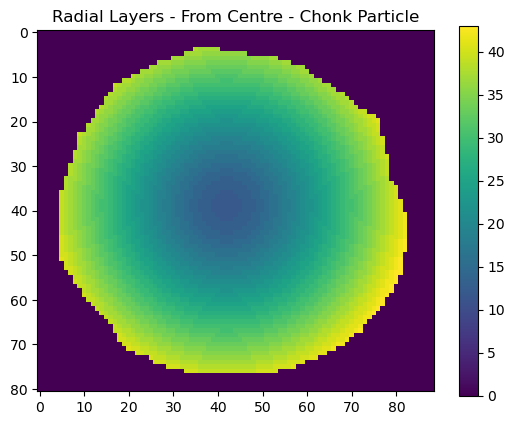

In [9]:
plt.imshow(np.array(grapes_analysis_2['GRAPES_distance_transform'][9754])[0][27], cmap = 'viridis')
plt.title('Radial Layers - From Centre - Chonk Particle')
color_bar = plt.colorbar()
plt.show()

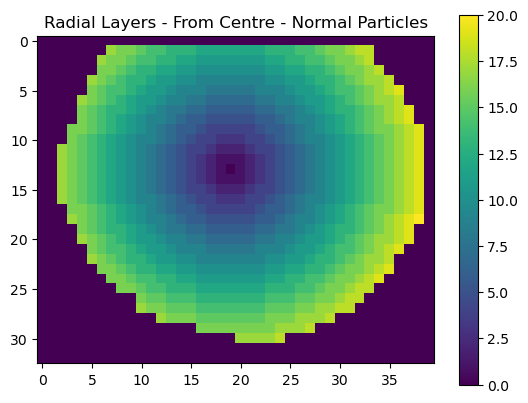

In [10]:
plt.imshow(np.array(grapes_analysis_2['GRAPES_distance_transform'][1])[0][8], cmap = 'viridis')
plt.title('Radial Layers - From Centre - Normal Particles')
color_bar = plt.colorbar()
plt.show()

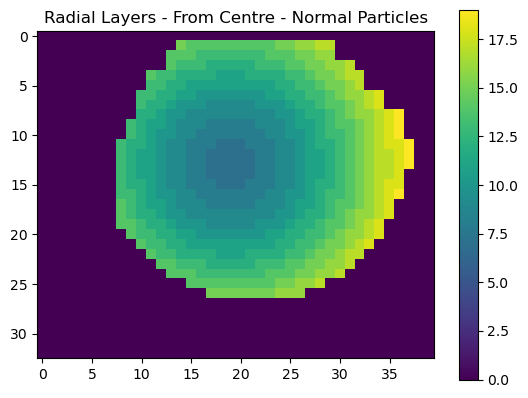

In [11]:
plt.imshow(np.array(grapes_analysis_2['GRAPES_distance_transform'][1])[0][15], cmap = 'viridis')
plt.title('Radial Layers - From Centre - Normal Particles')
color_bar = plt.colorbar()
plt.show()